Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [30]:
%matplotlib inline
!pip install category_encoders
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_columns', 50)

from sklearn.ensemble import RandomForestClassifier

import category_encoders as ce

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.pipeline import make_pipeline


pd.set_option('display.float_format', '{:.2f}'.format)

In [86]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

    
# If you're working locally:
else:
    DATA_PATH = '../data/'
    

In [87]:
import pandas as pd
import numpy as np

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [33]:
train.isnull().sum()


id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [34]:
train.head()
values = pd.DataFrame(train.status_group.value_counts())
values['percent_of_total'] = values.status_group/sum(values.status_group)*100
values.head()

,status_group,percent_of_total
functional,32259,54.31
non functional,22824,38.42
functional needs repair,4317,7.27


In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
r

In [36]:
conts = train.select_dtypes('number')
conts.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.00,59400.00,59400.00,59400.00,59400.00,59400.00,59400.00,59400.00,59400.00,59400.00
mean,37115.13,317.65,668.30,34.08,-5.71,0.47,15.30,5.63,179.91,1300.65
std,21453.13,2997.57,693.12,6.57,2.95,12.24,17.59,9.63,471.48,951.62
min,0.00,0.00,-90.00,0.00,-11.65,0.00,1.00,0.00,0.00,0.00
25%,18519.75,0.00,0.00,33.09,-8.54,0.00,5.00,2.00,0.00,0.00
50%,37061.50,0.00,369.00,34.91,-5.02,0.00,12.00,3.00,25.00,1986.00
75%,55656.50,20.00,1319.25,37.18,-3.33,0.00,17.00,5.00,215.00,2004.00
max,74247.00,350000.00,2770.00,40.35,-0.00,1776.00,99.00,80.00,30500.00,2013.00


In [37]:
train.select_dtypes('object').describe()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,59400,55765,55745,59400,59400,59029,59400,59400,59400,56066,59400,55523,31234,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,356,1897,2145,37400,9,19287,21,125,2092,2,1,12,2696,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6,3
top,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,572,9084,17402,3563,10248,508,5294,2503,307,51011,59400,36793,682,38852,26780,26780,26780,40507,52490,25348,25348,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259


In [38]:
columns = train.select_dtypes('object').columns.tolist()
for feats in columns:
  print(feats)
  print(train[feats].unique())

date_recorded
['2011-03-14' '2013-03-06' '2013-02-25' '2013-01-28' '2011-07-13'
 '2011-03-13' '2012-10-01' '2012-10-09' '2012-11-03' '2011-08-03'
 '2011-02-20' '2013-02-18' '2012-10-14' '2013-03-15' '2012-10-20'
 '2011-08-04' '2011-07-04' '2011-09-04' '2011-07-22' '2011-02-22'
 '2011-02-27' '2013-02-10' '2011-10-04' '2013-11-03' '2013-01-21'
 '2013-01-16' '2011-07-11' '2013-03-05' '2013-03-16' '2011-03-23'
 '2011-03-16' '2013-03-19' '2011-03-11' '2011-02-23' '2013-03-28'
 '2011-07-16' '2011-03-27' '2013-02-11' '2013-10-03' '2011-03-12'
 '2011-07-07' '2013-01-15' '2013-03-18' '2012-10-22' '2013-02-05'
 '2011-07-27' '2011-04-04' '2013-02-21' '2011-08-18' '2011-07-31'
 '2011-08-01' '2011-07-14' '2013-02-22' '2013-07-03' '2013-08-03'
 '2013-01-22' '2011-03-22' '2013-05-03' '2013-01-19' '2013-02-09'
 '2011-01-04' '2013-02-04' '2011-03-05' '2011-03-31' '2013-02-27'
 '2011-08-07' '2011-03-30' '2012-10-23' '2011-03-02' '2011-03-04'
 '2013-03-14' '2012-10-18' '2011-08-08' '2011-09-05' '2011-04-

In [39]:
train.recorded_by.value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [40]:
train.latitude.value_counts()

-0.00     1812
-6.99        2
-2.49        2
-2.52        2
-6.96        2
          ... 
-10.86       1
-3.15        1
-3.31        1
-9.08        1
-2.60        1
Name: latitude, Length: 57517, dtype: int64

In [41]:
train.longitude.value_counts()

0.00     1812
39.09       2
39.11       2
37.54       2
38.18       2
         ... 
38.71       1
40.12       1
34.67       1
39.43       1
34.89       1
Name: longitude, Length: 57516, dtype: int64

In [42]:
train.ward.value_counts()
train.subvillage.value_counts()

Madukani      508
Shuleni       506
Majengo       502
Kati          373
Mtakuja       262
             ... 
Piriri          1
Kemory          1
Makoteni B      1
Doga Juu        1
Ushili          1
Name: subvillage, Length: 19287, dtype: int64

In [88]:
def wrangle(X):
    
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['age'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    X = X.drop(columns=['recorded_by', 'id'])
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # longitude: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['longitude'].fillna(X.groupby(['ward'])['longitude'].transform('mean'), inplace=True)
    X['longitude'].fillna(X.groupby(['district_code'])['longitude'].transform('mean'), inplace=True)
    X['longitude'].fillna(X.groupby(['region_code'])['longitude'].transform('mean'), inplace=True)
    X['longitude'].fillna(X['longitude'].mean(), inplace=True)                                         
    
    # gps_height: replace nan values with the mean of the smallest geographical region possible
    # Excluding subvillage due to missing values
    X['gps_height'].fillna(X.groupby(['ward'])['gps_height'].transform('mean'), inplace=True)
    X['gps_height'].fillna(X.groupby(['district_code'])['gps_height'].transform('mean'), inplace=True)
    X['gps_height'].fillna(X.groupby(['region_code'])['gps_height'].transform('mean'), inplace=True)
    X['gps_height'].fillna(X['gps_height'].mean(), inplace=True)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    # For categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
      # Engineered features from data exploration and cleaning notebook
    X['amount_tsh_above_1000'] = X['amount_tsh'] > 1000
    X['water_quality_good_and_seasonal'] = (X['quality_group'] == 'good') & (X['quantity'] == 'seasonal')
    X['water_quality_good_and_dry'] = (X['quality_group'] == 'good') & (X['quantity'] == 'dry')
    X['water_quality_good_and_insufficient'] = (X['quality_group'] == 'good') & (X['quantity'] == 'insufficient')
    X['water_quality_good_and_enough'] = (X['quality_group'] == 'good') & (X['quantity'] == 'enough')
    X['water_quality_good'] = X['quality_group'] == 'good'
    X['age'] = 2020 - X['construction_year']
    X['years_since_inspection'] = 2019 - X['year_recorded']
    X['x_coordinate'] = np.cos(X['latitude'] * np.cos(X['longitude']))
    X['y_coordinate'] = np.cos(X['latitude'] * np.sin(X['longitude']))
    X['z_coordinate'] = np.sin(X['latitude'])
    X['pop/amount_tsh_above_1000'] = X['amount_tsh_above_1000']/ X['population']
    X['pop/age'] = X['population'] / X['age']
    
    return X

In [89]:
train = wrangle(train)
test = wrangle(test)

In [90]:
drop = ["funder",
        "ward",
]

train.drop(drop, axis=1, inplace=True)
test.drop(drop, axis=1, inplace=True)

In [91]:
X_train = train
y_train = train['status_group']

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size = 0.80, test_size = 0.20, 
    stratify = y_train, random_state = 42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((47520, 51), (11880, 51), (47520,), (11880,))

In [92]:
X_train.describe(exclude='number').T.sort_values(by='unique')


,count,unique,top,freq
water_quality_good,47520,2,True,40598
water_quality_good_and_insufficient,47520,2,False,37276
water_quality_good_and_dry,47520,2,False,44035
water_quality_good_and_seasonal,47520,2,False,44701
amount_tsh_above_1000,47520,2,False,45127
water_quality_good_and_enough,47520,2,True,23916
status_group,47520,3,functional,25807
public_meeting,47520,3,True,40838
permit,47520,3,True,31071
source_class,47520,3,groundwater,36638


In [93]:
categorical_features = [
    'quantity','extraction_type',
    'extraction_type_group','management',
    'management_group','source','source_type',
    'waterpoint_type','basin','region',
    'scheme_management','extraction_type_class',
    'payment','payment_type','waterpoint_type_group', 
    
    
]

numeric_features = X_train.select_dtypes('number').columns.tolist()
features = categorical_features + numeric_features

X_train_subset = X_train[features]
X_val_subset = X_val[features]
X_test = test[features]


In [ ]:
from xgboost import XGBClassifier 

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    QuantileTransformer(),
    IterativeImputer(), 
    XGBClassifier( learning_rate =0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4,scale_pos_weight=1,seed=42)
    
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train_subset, y_train)
print('Validation Accuracy', pipeline.score(X_val_subset, y_val))
y_pred = pipeline.predict(X_test)

# Write submission csv file
#submission = sample_submission.copy()
#submission['status_group'] = y_pred
#submission.to_csv('submission-XGB2_3csv', index=False)

C:\Users\ryanh\Anaconda2\envs\unit2\lib\site-packages\sklearn\impute\_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


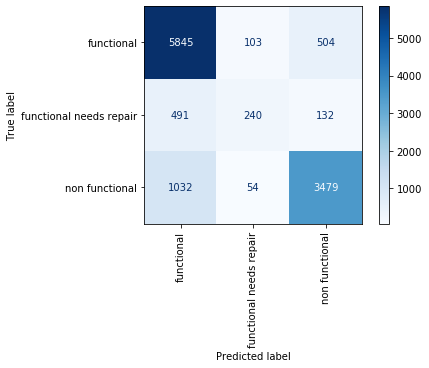

In [95]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val_subset, y_val, 
                      xticks_rotation='vertical', 
                      values_format='.0f',
                      cmap='Blues');

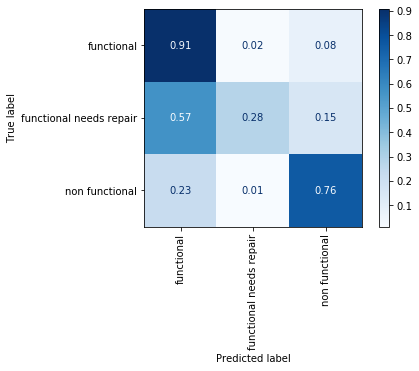

In [96]:
plot_confusion_matrix(pipeline, X_val_subset, y_val, 
                      xticks_rotation='vertical', 
                      normalize='true',
                      values_format='.2f',
                      cmap='Blues');